<font size="6"> **Model Building: Non Overlap Voters Ensembling** </font>

In [1]:
%%capture
%run 00_mlmod_load_data.ipynb

In [2]:
MODEL_VERSION = 'v02'
print('Model version: ', MODEL_VERSION)

Model version:  v02


In [3]:
OUTPATH =  "../data/" + cfg['output']['main'] + "/" + cfg['output']['alpha_factors_ml']['folder'] + "/" + MODEL_VERSION +"/"
OUTFILE1 = cfg['output']['alpha_factors_ml']['features']
OUTFILE2 = cfg['output']['alpha_factors_ml']['targets']
OUTFILE3 = cfg['output']['alpha_factors_ml']['preds']
OUTFILE4 = cfg['output']['alpha_factors_ml']['model']

In [4]:
RND_SEED = 123
KFOLDS = 3

In [5]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (16, 8)
sns.set_context("talk")
pd.set_option('precision', 4)

In [6]:
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor

import pickle

In [7]:
# Overwrite persisted versions of sampled data
X_train_smp = pd.read_csv(OUTPATH + 'x_train_smp.csv', parse_dates=['date'], index_col=[0,1])
y_train_smp = pd.read_csv(OUTPATH + 'y_train_smp.csv', parse_dates=['date'], index_col=[0,1])
y_train_smp = y_train_smp[target_col]

In [8]:

direction_accuracy = make_scorer(mle_utils.direction_accuracy_func, greater_is_better=True, kind='global')
upwards_direction_accuracy = make_scorer(mle_utils.direction_accuracy_func, greater_is_better=True, kind='upwards')
downwards_direction_accuracy = make_scorer(mle_utils.direction_accuracy_func, greater_is_better=True, kind='downwards')
weighted_direction_accuracy = make_scorer(mle_utils.direction_accuracy_func, greater_is_better=True, kind='weighted', w_fp=2., w_fn=1.)

In [9]:
scoring = {'neg_root_mean_squared_error':'neg_root_mean_squared_error',
           'w_accuracy': weighted_direction_accuracy,
           'accuracy': direction_accuracy,
          'up_accuracy': upwards_direction_accuracy,
          'down_accuracy': downwards_direction_accuracy}

In [10]:
select_sum_cols = ['mean_test_w_accuracy', 'std_test_w_accuracy', 'rank_test_w_accuracy',
                   'mean_test_accuracy', 'mean_test_up_accuracy','mean_test_down_accuracy', 'mean_test_neg_root_mean_squared_error']

# Ridge Weekly Sampling

## CV Grid Search

In [11]:
ridge_tscv_smp = TimeSeriesSplit(n_splits=KFOLDS).split(y_train_smp)

In [12]:
hpgrid_ridge = {'alpha': [10.0**x for x in range(-3,3)]}
ridge = Ridge(fit_intercept=False, random_state=RND_SEED)

In [13]:
ridge_cv = GridSearchCV(ridge, hpgrid_ridge, scoring=scoring,
                        n_jobs=-1, refit='w_accuracy',
                        cv=ridge_tscv_smp, return_train_score=True)
res_ridge_cv = ridge_cv.fit(X_train_smp, y_train_smp)

In [14]:
ridge_params_df = pd.DataFrame(res_ridge_cv.cv_results_['params'])
ridge_metrics_df = pd.DataFrame(res_ridge_cv.cv_results_)[select_sum_cols]
ridge_sum_df = ridge_params_df.join(ridge_metrics_df)
ridge_sum_df.sort_values(by='rank_test_w_accuracy').head(20)

,alpha,mean_test_w_accuracy,std_test_w_accuracy,rank_test_w_accuracy,mean_test_accuracy,mean_test_up_accuracy,mean_test_down_accuracy,mean_test_neg_root_mean_squared_error
3,1.000,0.4315,0.0295,1,0.5595,0.7504,0.3152,-0.0287
2,0.100,0.4217,0.0154,2,0.5557,0.7736,0.2791,-0.0287
4,10.000,0.4173,0.0271,3,0.5520,0.7844,0.2554,-0.0285
1,0.010,0.4113,0.0141,4,0.5483,0.7844,0.2497,-0.0289
0,0.001,0.4085,0.0217,5,0.5435,0.7706,0.2567,-0.0299
5,100.000,0.3913,0.0048,6,0.5487,0.9112,0.0930,-0.0286


In [15]:
select_cvdet_cols = ['split0_test_w_accuracy','split1_test_w_accuracy', 'split2_test_w_accuracy', 'mean_test_w_accuracy', 'std_test_w_accuracy', 'rank_test_w_accuracy',
                    'mean_test_accuracy', 'mean_test_neg_root_mean_squared_error']

In [16]:
champ_ridge_idx = 2
champ_ridge_hparms = res_ridge_cv.cv_results_['params'][champ_ridge_idx]
champ_ridge = Ridge(fit_intercept=False, random_state=RND_SEED)
champ_ridge.set_params(**champ_ridge_hparms)
champ_ridge.fit(X_train_smp, y_train_smp)

Ridge(alpha=0.1, copy_X=True, fit_intercept=False, max_iter=None,
      normalize=False, random_state=123, solver='auto', tol=0.001)

In [17]:
p_train_ridge = pd.Series(index=y_train_full.index, data=champ_ridge.predict(X_train_full))
p_test_ridge = pd.Series(index=y_test_full.index, data=champ_ridge.predict(X_test_full))

In [18]:
ridge_metrics_cvdet =  pd.DataFrame(res_ridge_cv.cv_results_)[select_cvdet_cols]
ridge_metrics_cvdet['alpha'] = ridge_params_df['alpha']

In [19]:
champ_ridge_score = ridge_metrics_cvdet.loc[champ_ridge_idx,'mean_test_w_accuracy']
champ_ridge_alpharank = ridge_metrics_cvdet.loc[champ_ridge_idx, 'alpha']
top_ridge_score = ridge_metrics_cvdet.loc[ridge_metrics_cvdet['rank_test_w_accuracy']==1, 'mean_test_w_accuracy'].iloc[0]
top_ridge_alpharank = ridge_metrics_cvdet.loc[ridge_metrics_cvdet['rank_test_w_accuracy']==1, 'alpha'].iloc[0]
champ_ridge_score, champ_ridge_alpharank, top_ridge_score, top_ridge_alpharank

(0.4216608968189812, 0.1, 0.43148847927030887, 1.0)

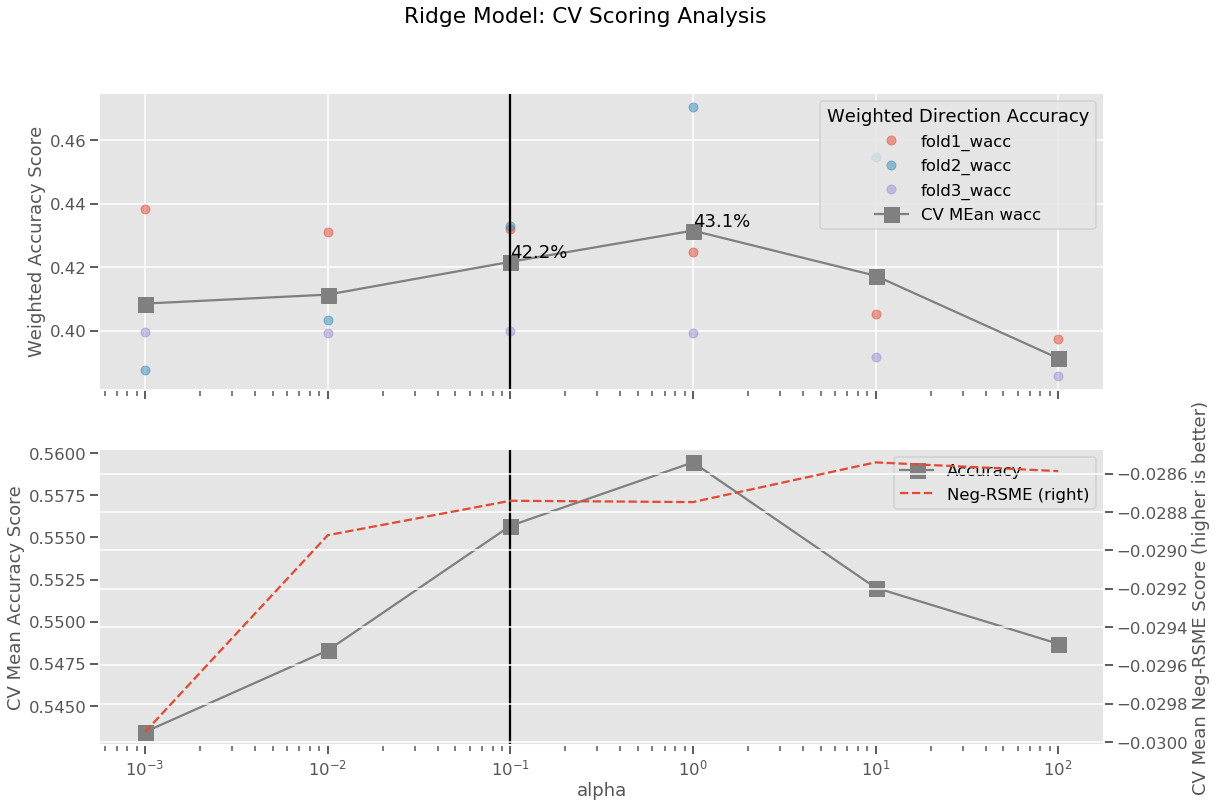

In [20]:
fig, axs = plt.subplots(2,1, sharex=True, figsize=(18,12))

plt.suptitle("Ridge Model: CV Scoring Analysis")
ax = axs[0]
ridge_metrics_cvdet.plot(ax=ax, x='alpha', y=['split0_test_w_accuracy','split1_test_w_accuracy', 'split2_test_w_accuracy'],
                        logx=True, style='o', alpha=0.5, label=['fold1_wacc', 'fold2_wacc', 'fold3_wacc'])
ridge_metrics_cvdet.plot(ax=ax, x='alpha', y='mean_test_w_accuracy',
                        logx=True, marker='s', markersize=15, color='grey', label='CV MEan wacc')
ax.legend(title="Weighted Direction Accuracy")
ax.set_ylabel('Weighted Accuracy Score')
ax.text(top_ridge_alpharank, top_ridge_score, f'{top_ridge_score:0.1%}', va='bottom', ha='left')
ax.text(champ_ridge_alpharank, champ_ridge_score, f'{champ_ridge_score:0.1%}', va='bottom', ha='left')

ax = axs[1]
ridge_metrics_cvdet.plot(ax=ax, x='alpha', y='mean_test_accuracy',
                         label='Accuracy',color='grey',
                        logx=True,marker='s', markersize=15)
plt.ylabel('CV Mean Accuracy Score')

ridge_metrics_cvdet.plot(ax=ax, x='alpha', y='mean_test_neg_root_mean_squared_error',
                         secondary_y=True,
                         label='Neg-RSME',
                         linestyle='--',
                        logx=True)

plt.ylabel('CV Mean Neg-RSME Score (higher is better)')

for ax in axs:
    ax.axvline(x=champ_ridge_alpharank, color='black')
    
plt.show()


There are several models that may be nice to select, model ranked 2 (alpha=0.1) is a good choice:
* Hyperparameter Discusion:
    * `alpha=0.1`: Alpha is a regularization parameter, the higher its value, the more that model coefficient shrinked, when alpha=0, Ridge model is the same as a regular Linear Regression. Increasing alpha allows the model to accomodate slightly correlated features as well as, avoiding overfitting
* The best performant model is at `alpha=1`, however, cv score yield the highest standard deviation, that means that in test dataset, this score estimation may not be accurate.
* On the other hand, higher regularization means that the model tends to generalize better. However, looking at `fold2_wacc`, it is the best among any alpha, that means that `alpha=1` is the best only for that fold, skewing the mean cv. Better to look at other models


## Performance Estimation on Test

In [21]:
ridge_sum_df = mle_utils.predict_and_score(champ_ridge,
                                           X_train_full, y_train_full,
                                           X_test_full, y_test_full, kind='reg')
rename_cols = {'valid_acc': 'test_acc',
           'valid_acc_target<0': 'test_acc_target<0',
           'valid_acc_target>0': 'test_acc_target>0'}
ridge_sum_df.rename(inplace=True, index=rename_cols)
ridge_sum_df

train_pmean           0.0036
train_score           0.0008
valid_pmean           0.0089
valid_score           0.0015
train_acc_target<0    0.3198
train_acc_target>0    0.7729
train_acc             0.5746
test_acc              0.5108
test_acc_target<0     0.1444
test_acc_target>0     0.8702
dtype: float64

## Interpertation

In [22]:
#### ~TODO

## Prediction analysis

In [23]:
y_pred = pd.concat([p_train_ridge.to_frame('p_ridge_smp'), p_test_ridge.to_frame('p_ridge_smp')], axis=0)
y_pred['ml_alpha_ridge_smp'] = mle_utils.get_pred_alpha(y_pred['p_ridge_smp'], kind='reg', n_bins=51)
y_pred[split_col] = split

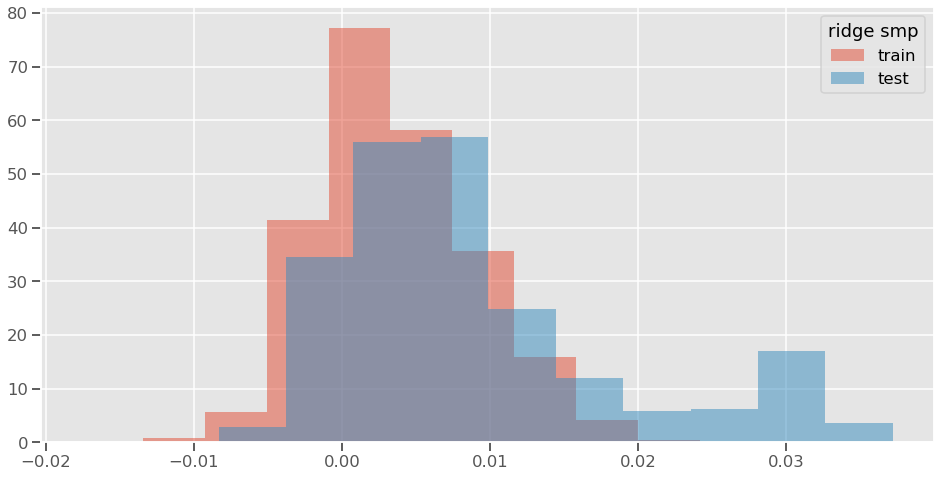

In [24]:
fig, ax = plt.subplots(1,1, sharex=True)

mask_train = y_pred[split_col] == 'train'
mask_test = y_pred[split_col] == 'test'

y_pred.loc[mask_train, 'p_ridge_smp'].hist(ax=ax, density=True, alpha=0.5, label='train')
y_pred.loc[mask_test, 'p_ridge_smp'].hist(ax=ax, density=True,  alpha=0.5, label='test')
ax.legend(title='ridge smp')

plt.show()

## Alpha Factor Analysis

In [25]:
alpha_factors

['Mean_Reversion_Sector_Neutral_Smoothed',
 'Momentum_1YR_Smoothed',
 'Overnight_Sentiment_Smoothed']

In [26]:
alpha_factors_df = y_pred[[split_col, 'ml_alpha_ridge_smp']].copy()
alpha_factors_df = alpha_factors_df.join(features_df[alpha_factors], how='left')
alpha_factors_df['avg_combi_alpha'] = alpha_factors_df[alpha_factors].mean(axis=1)

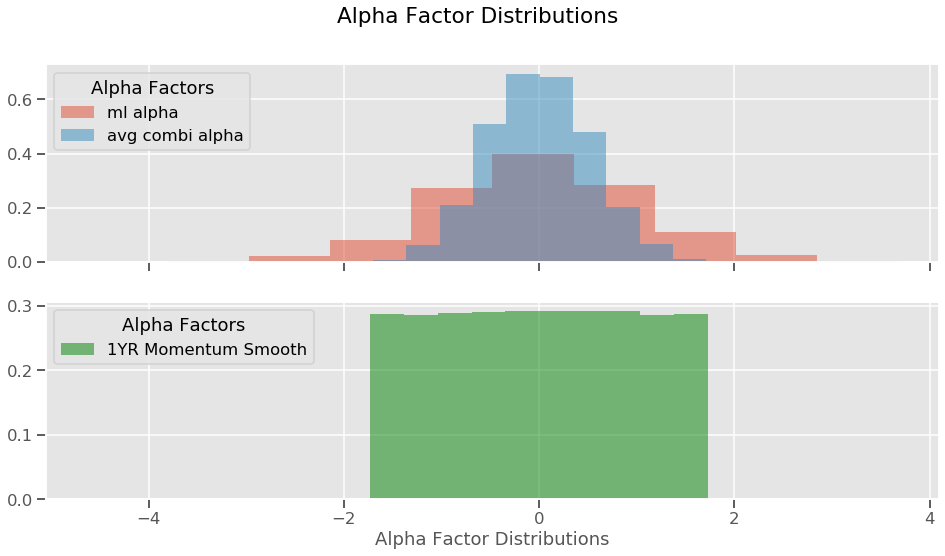

In [27]:
fig, axs = plt.subplots(2,1, sharex=True)

plt.suptitle('Alpha Factor Distributions')

ax = axs[0]
alpha_factors_df['ml_alpha_ridge_smp'].hist(ax=ax, density=True,  alpha=0.5, label='ml alpha')
alpha_factors_df['avg_combi_alpha'].hist(ax=ax, density=True, alpha=0.5, label='avg combi alpha')

ax = axs[1]
alpha_factors_df['Momentum_1YR_Smoothed'].hist(ax=ax, density=True, alpha=0.5, color='green', label='1YR Momentum Smooth')
ax.set_xlabel('Alpha Factor Distributions')

for ax in axs:
    ax.legend(title='Alpha Factors', loc='upper left')

plt.show()

## Write Ridge Sampling Model

In [28]:
y_pred.to_csv(OUTPATH + OUTFILE3)

In [29]:
with open(OUTPATH + OUTFILE4, 'wb') as file:
    pickle.dump(champ_ridge, file)

# Non-Overlapping Voting Ensembles

## Ridge

### Ensemble

In [30]:
hparams_ridge = {'alpha': .1}

In [31]:
ridge = Ridge(fit_intercept=False, random_state=RND_SEED, **hparams_ridge)

In [32]:
ridge_nov = mle_utils.NoOverlapVoterRegressor(base_estimator=ridge, n_skip_samples=4)
ridge_nov.fit(X_train_full[features_nov], y_train_full)

NoOverlapVoterRegressor(base_estimator=Ridge(alpha=0.1, copy_X=True,
                                             fit_intercept=False, max_iter=None,
                                             normalize=False, random_state=123,
                                             solver='auto', tol=0.001),
                        n_skip_samples=4)

In [33]:
p_train_ridge_nov = pd.Series(index=y_train_full.index, data=ridge_nov.predict(X_train_full[features_nov]))
p_test_ridge_nov = pd.Series(index=y_test_full.index, data=ridge_nov.predict(X_test_full[features_nov]))


In [34]:
ridge_nov_sum_df = mle_utils.predict_and_score(ridge_nov,
                                        X_train_full[features_nov], y_train_full,
                                        X_test_full[features_nov], y_test_full, kind='reg')
ridge_nov_sum_df.rename(inplace=True, index=rename_cols)
ridge_nov_sum_df

train_pmean           0.0037
train_score           0.0008
valid_pmean           0.0100
valid_score           0.0015
train_acc_target<0    0.3170
train_acc_target>0    0.7761
train_acc             0.5752
test_acc              0.5061
test_acc_target<0     0.1284
test_acc_target>0     0.8767
dtype: float64

### Correlation over voter

In [35]:
ridge_voters = ridge_nov.estimators_

In [37]:
x_train_subsets = []
y_pred_subsets = []
n_rows = 1e6
for weekday in range(0, 4+1):
    x = X_train_full.loc[X_train_full[f'weekday_{weekday}']==1, features_nov]
    p = ridge_voters[weekday].predict(x)
    n_rows = min(n_rows, len(p))
    #p = pd.Series(index=x.index, data=p, name=f'preds_weekday{weekday}')
    x_train_subsets.append(x)
    y_pred_subsets.append(p[:n_rows])


In [38]:
nov_weekday_preds = np.column_stack(y_pred_subsets)

In [45]:
pd.DataFrame(nov_weekday_preds).corr()

,0,1,2,3,4
0,1.0000,-0.0284,-0.1092,-0.1070,-0.0740
1,-0.0284,1.0000,0.4654,0.3446,0.3149
2,-0.1092,0.4654,1.0000,0.5825,0.6725
3,-0.1070,0.3446,0.5825,1.0000,0.6667
4,-0.0740,0.3149,0.6725,0.6667,1.0000


## Random Forest

In [ ]:
hparams_rf = {'max_samples': 0.5,
            'max_features': 0.75,
            'min_samples_leaf': 500}

In [ ]:
rf = RandomForestRegressor(n_estimators=200, criterion='mse',
                            bootstrap=True,oob_score=True,
                            n_jobs=-1, random_state=RND_SEED, **hparams_rf)

In [ ]:
rf_nov = mle_utils.NoOverlapVoterRegressor(base_estimator=rf, n_skip_samples=4)
rf_nov.fit(X_train_full[features_nov], y_train_full)

In [ ]:
p_train_rf_nov = pd.Series(index=y_train_full.index, data=rf_nov.predict(X_train_full[features_nov]))
p_test_rf_nov = pd.Series(index=y_test_full.index, data=rf_nov.predict(X_test_full[features_nov]))

In [ ]:
rf_nov_sum_df = mle_utils.predict_and_score(rf_nov,
                                        X_train_full[features_nov], y_train_full,
                                        X_test_full[features_nov], y_test_full, kind='reg')
rf_nov_sum_df.rename(inplace=True, index=rename_cols)
rf_nov_sum_df

## NOV Voting Assessment

In [ ]:
nov_sum_df = rf_nov_sum_df.to_frame('rf_nov').join(ridge_nov_sum_df.to_frame('ridge_nov'))
nov_sum_df.T[['test_acc', 'test_acc_target<0', 'test_acc_target>0']]

In [ ]:
p_train_nov = p_train_rf_nov.to_frame('p_rf_nov')
p_train_nov['p_ridge_nov'] = p_train_ridge_nov
p_train_nov[split_col] = 'train'

corr_train = p_train_nov.corr()
corr_train

In [ ]:
p_test_nov = p_test_rf_nov.to_frame('p_rf_nov')
p_test_nov['p_ridge_nov'] = p_test_ridge_nov
p_test_nov[split_col] = 'test'

corr_test = p_test_nov.corr()
corr_test